# Analyze Tweet Data
## Part 2: Exploratory Data Analysis (EDA) and Data Visualization

## Table of Contents
- [Introduction](#intro)
- [EDA and Visualization](#analysis)
- [Conclusion](#conclusion)
- [Reference](#reference)

<a id='intro'></a>
## Introduction

In [9]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid', {'grid.linestyle': 'dotted'})

<a id='analysis'></a>
## EDA and Visualization
Three `.csv` files containing the cleaned version of the data from __Part 1: Data Wrangling__ were imported to this notebook by using pandas.

In [2]:
# read .csv files containing cleaned data
df_archive = pd.read_csv('data/twitter_archive_clean.csv')
df_master = pd.read_csv('data/twitter_archive_master.csv')
df_image = pd.read_csv('data/image_prediction_clean.csv')

### Data Wrangling
Assessment of the three datasets imported above revealed that the data types of the `tweet_id` columns in all these datasets and the `timestamp` column in the two Twitter Archive datasets were integer and string (object), respectively. Although the data types of `tweet_id` and `timestamp` had been changed to string (object) and datetime, respectively, as documented in the data wrangling efforts from Part 1, the data types of these two columns may have been reverted as a result of reading the cleaned data from the `.csv` files with pandas.

A sequence of steps similar to the one used in Part 1, _define_, _code_, and _test_, was used to change the data types of the `tweet_id` and `timestamp` columns back to string (object) and datetime, respectively, as shown in the code block below.

In [3]:
# correct data types of selected columns
df_list = [df_archive, df_master, df_image]
df_name = ['twitter_archive_clean.csv', 'twitter_archive_master.csv', 'image_prediction_clean.csv']

for i in range(len(df_list)):
    # columns with data types reverted back to those from uncleaned version
    col1 = df_list[i].columns[0] # tweet_id
    col2 = df_list[i].columns[1] # timestamp
    
    # data type of the column from uncleaned version
    col1_type = df_list[i][col1].dtype
    col2_type = df_list[i][col2].dtype
    
    # .csv file name
    print('{}. Dataframe: {}'.format(i+1, df_name[i]))
    
    # change data type (of tweet_id) to string
    df_list[i][col1] = df_list[i][col1].astype(dtype = 'str')
    
    # column name: data type before/after
    print('  - {}: from "{}" to "{}"'.format(col1, col1_type, df_list[i][col1].dtype))
    
    if i != 2: # df_image does not have timestamp column
        # change data type (of timestamp) to string
        df_list[i][col2] = pd.to_datetime(arg = df_list[i][col2])

        # column name: data type before/after
        print('  - {}: from "{}" to "{}"'.format(col2, col2_type, df_list[i][col2].dtype))

1. Dataframe: twitter_archive_clean.csv
  - tweet_id: from "int64" to "object"
  - timestamp: from "object" to "datetime64[ns, UTC]"
2. Dataframe: twitter_archive_master.csv
  - tweet_id: from "int64" to "object"
  - timestamp: from "object" to "datetime64[ns, UTC]"
3. Dataframe: image_prediction_clean.csv
  - tweet_id: from "int64" to "object"


### 1. Time of the Day when _WeRateDogs (@dogrates)_ Shows Most Activity
#### Explore

In [4]:
# sub-dataset for timestamps of original tweets
df_1 = df_archive.query('retweet == False')[['timestamp']]

# hour and day parts of timestamps
df_1['hour'] = df_1.timestamp.dt.hour
df_1['day'] = df_1.timestamp.dt.weekday

# number of original tweets in each hour on day 0 (Mondays)
df_1.groupby('day').hour.value_counts()[0]

hour
0     46
1     46
16    39
3     35
2     34
17    30
15    28
23    23
18    15
4     14
19    12
20    11
21    11
22     8
5      2
14     2
13     1
Name: hour, dtype: int64

#### Feature Engineering

In [5]:
# percentage of original tweets from each hour on a given day of the week
df_1 = df_1.groupby('day').hour.value_counts() / df_1.groupby('day').hour.agg('count') * 100
df_1 = pd.DataFrame(df_1).rename(columns = {'hour':'tweet_percentage'})

# reset multi-index
df_1.reset_index(level = ['day','hour'], inplace = True)

df_1.head()

,day,hour,tweet_percentage
0,0,0,12.885154
1,0,1,12.885154
2,0,16,10.924370
3,0,3,9.803922
4,0,2,9.523810


In [6]:
# index to which new row can be added
ind = df_1.index.max() + 1

# daily hours available: 0, 1, ..., 22, 23
hours = [hour for hour in range(24)]

# if the hour is not recorded in the dataframe for given day
for d in df_1.day.unique():
    for hr in hours:
        if hr not in df_1.query('day == @d').hour.unique():
            
            # add new row with day, hour, and 0 percentage of tweet-posting activity
            df_1.loc[ind] = d, hr, 0
            
            # update index for the next row addition
            ind += 1

df_1.tail()

,day,hour,tweet_percentage
163,6,10,0.0
164,6,11,0.0
165,6,12,0.0
166,6,13,0.0
167,6,14,0.0


In [7]:
# sort values by three columns and reset index
df_1.sort_values(by = ['day', 'hour', 'tweet_percentage'], inplace = True)
df_1.reset_index(drop = True, inplace = True)

df_1.head()

,day,hour,tweet_percentage
0,0,0,12.885154
1,0,1,12.885154
2,0,2,9.523810
3,0,3,9.803922
4,0,4,3.921569


In [8]:
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow = [day for day in np.arange(7)] # integers representing days of a week

# dictionary mapping integers to days of a week
dow_dict = {}
for key in dow:
    # integer: day of week (ex 0: Monday)
    dow_dict[key] = day_of_week[key]

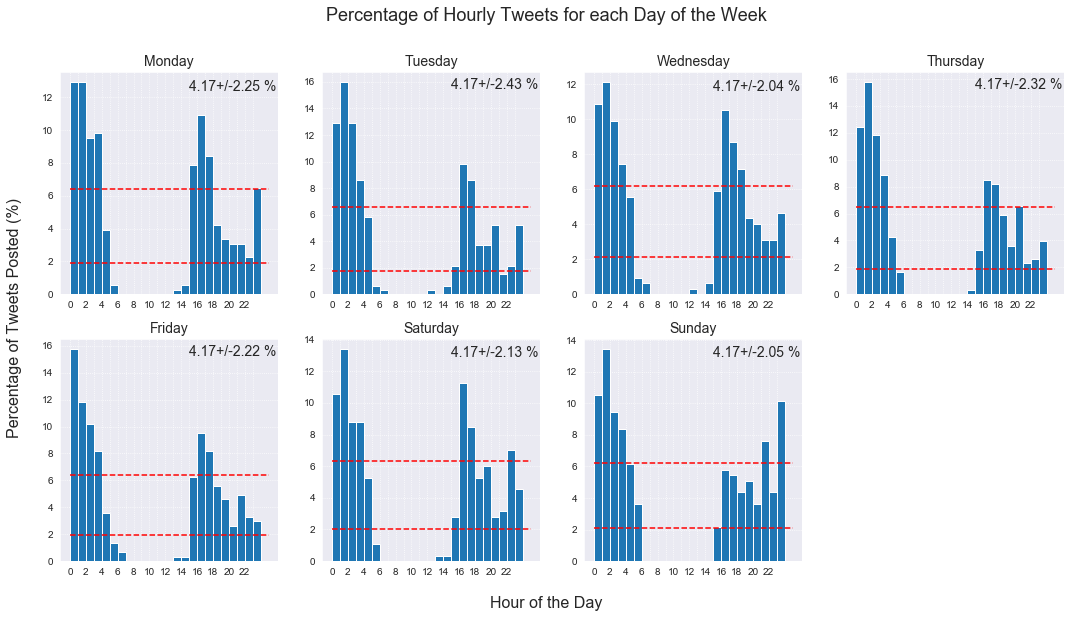

In [10]:
# create figure with 2-by-4 subplots
rows = 2
cols = 4
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (18,9))

# add figure title and common x, y axes labels for all subplots
fig.suptitle('Percentage of Hourly Tweets for each Day of the Week', fontsize = 18)
fig.text(x = 0.5, y = 0.06, s = 'Hour of the Day', ha = 'center', va = 'center', fontsize = 16)
fig.text(x = 0.09, y = 0.5, s = 'Percentage of Tweets Posted (%)', ha = 'center', va = 'center', rotation = 'vertical', fontsize = 16)

# for each subplot, ax[row, col]
for row in np.arange(rows):
    for col in np.arange(cols):
        
        if row == 0: # in first row, col number = integer for the given day
            df = df_1.query('day == @col') # filter data for the given day
            day_name = dow_dict[col] # find name of the day
            
        else:
            # delete last (eighth) subplot because there is only seven days in a week
            if col == cols - 1:
                fig.delaxes(ax[row, col])
                break
            
            # in second row, col number = integer for the given day - 4
            df = df_1.query('day == @col + 4')
            day_name = dow_dict[col + 4]

        # set up xtick locations and labels
        width = 2
        x_loc = list(df.hour * width)
        labels = [label for label in np.arange(24)]
        
        # bar plots for percentage of hourly tweets for each day of week
        ax[row, col].bar(x = x_loc, height = df.tweet_percentage, width = width, align = 'edge')
        
        # label suplot with name of the day
        ax[row, col].set_title(day_name, fontsize = 14)
        
        # label xticks by increments of two: 0, 2, ..., 22
        for i in range(len(labels)):
            if labels[i] % 2 != 0:
                labels[i] = ''
        
        # add xtick labels to the subplot
        ax[row, col].set_xticks(ticks = x_loc)
        ax[row, col].set_xticklabels(labels = labels)
        
        # statistics for percentages of tweets across hours in a given day
        avg = df.tweet_percentage.mean()
        sd = df.tweet_percentage.std()
        lower = avg - sd/2
        upper = avg + sd/2
        
        # horizontal lines for mean percentage +,- standard deviation/2
        ax[row, col].hlines(y = lower, xmin = 0, xmax = 50, colors = 'red', linestyles = '--')
        ax[row, col].hlines(y = upper, xmin = 0, xmax = 50, colors = 'red', linestyles = '--')
        
        # legend for statistics
        ax[row, col].text(x = 30, y = df.tweet_percentage.max()-0.5, s = '{}+/-{} %'.format(round(avg, 2), round(sd/2, 2)), fontsize = 14)

<a id='conclusion'></a>
## Conclusion

<a id='reference'></a>
## Reference